Jennifer Statter

Objective:
The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

#### Library

In [1]:
# TensorFlow
# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

In [2]:
# Library 
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
from sklearn.utils import class_weight
# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
                                                                                                 
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Opening Files and Quick Overveiw


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#import images
#import labels
images = np.load("/content/drive/MyDrive/samples/images.npy")
labels = pd.read_csv("/content/drive/MyDrive/samples/Labels.csv")

In [5]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


* There are 4750 RGB images of shape 128 x 128 X 3, each image having 3 channels.
* The labels have 4750 rows and one Column, which is a concern to address in preprocessing because there are only 12 classes of seeds in our project. 



In [6]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [7]:
labels.tail()

,Label
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent
4749,Loose Silky-bent


* The 4750 rows will have to be broken into 12 catagories by counting the unique values. Then these unique values will be used to create column features. 


### EDA

In [8]:
labels["Label"].nunique()

12

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

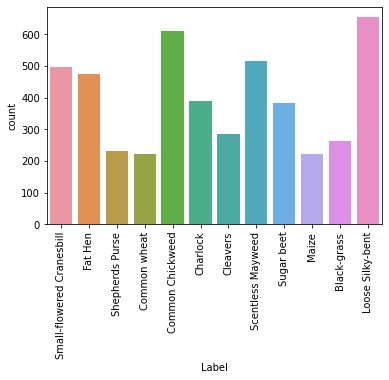

In [9]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

* The data is imbalanced so we will treat the 
 minority classes with a weight increase.  

In [10]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
# This will help images contrast against the dual background.
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [11]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)   
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                       # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

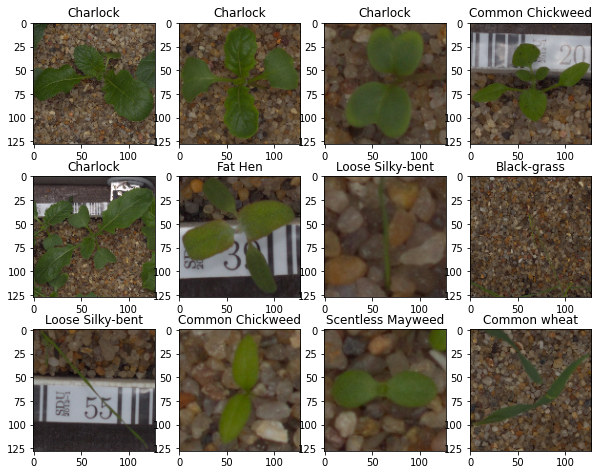

In [12]:
plot_images(images,labels)

* Some of the same species of seedlings appear to look different (ex. scentless mayweed). This may be due to the seedlings being at different stages. 

##### Reducing the image size to save computing power

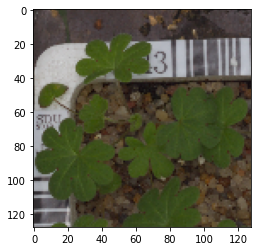

In [13]:
# Original version of image
plt.imshow(images[3])

In [14]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

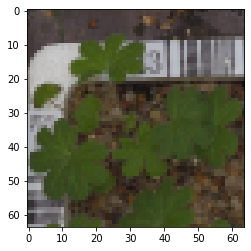

In [15]:
plt.imshow(images_decreased[3])

* The image is still legible to the human eye so it should be identifiable for the CNN.
* The edge of the seedling image looks like pixel art. 

In [16]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

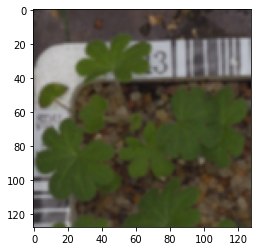

In [17]:
plt.imshow(images_gb[3])

* The seedling in the image's edges look smoother after being treated with gaussian blur. 
* The blurred image has no increased resemblance to the original version compared to the decreased image size.
* Even though it looks better it will not be used because it does not add any relative information.


In [18]:
normalized = images.astype('float32')/255.0

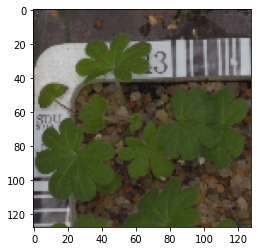

In [19]:
plt.imshow(normalized[3])

#### Summary of EDA

* The dataset is imbalanced, so it will need to be treated. 
* The reduced image size will be used to decrease the computational cost.
* Gaussian blur improves the appearance of the images but does not add any additional information so it will not be used.

### Preprocessing

#### Splitting the Dataset

In [20]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=1,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=1,stratify=y_temp)


In [21]:
print('Train set shape')
print(X_train.shape,y_train.shape)
print('Validation set shape')
print(X_val.shape,y_val.shape)
print('Test set shape')
print(X_test.shape,y_test.shape)

Train set shape
(3847, 64, 64, 3) (3847, 1)
Validation set shape
(428, 64, 64, 3) (428, 1)
Test set shape
(475, 64, 64, 3) (475, 1)


#### Fixing the Class Imbalance with Weights

In [22]:
#labels["Label"].nunique()
#The below code can be used to treat the class imbalance by increasing the weights of the minority classes.

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7974709784411277,
 1: 0.8348524305555556,
 2: 1.714349376114082,
 3: 1.7909683426443204,
 4: 0.6476430976430977,
 5: 1.0145042194092826,
 6: 1.3818247126436782,
 7: 0.7669457735247209,
 8: 1.0275106837606838,
 9: 1.7909683426443204,
 10: 1.5050860719874803,
 11: 0.604874213836478}

#### Making the Data Compatible

In [23]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder 

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [24]:
print('Train set shape')
print(X_train.shape,y_train_encoded.shape)
print('Validation set shape')
print(X_val.shape,y_val_encoded.shape)
print('Test set shape')
print(X_test.shape,y_test_encoded.shape)

Train set shape
(3847, 64, 64, 3) (3847, 12)
Validation set shape
(428, 64, 64, 3) (428, 12)
Test set shape
(475, 64, 64, 3) (475, 12)


In [25]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

###**Model Building - Convolutional Neural Network (CNN)**

* Epoch will be kept low at 10 for the initial model and 2nd model to decrease run time while I tweek with the hyper parameters. A final model will have 15 epochs once the hyper parameters and final improvements are decided on. 

####Initial Model

In [26]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [27]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [28]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [29]:
#Fitting the model on the train data
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=10,
            validation_data=(X_val_normalized,y_val_encoded),
            class_weight=class_weights,
            batch_size=32,
            verbose=2
  )

Epoch 1/10
121/121 - 34s - loss: 2.6666 - accuracy: 0.2111 - val_loss: 2.1448 - val_accuracy: 0.3435 - 34s/epoch - 285ms/step
Epoch 2/10
121/121 - 33s - loss: 2.1492 - accuracy: 0.3369 - val_loss: 1.8282 - val_accuracy: 0.3598 - 33s/epoch - 275ms/step
Epoch 3/10
121/121 - 33s - loss: 1.7850 - accuracy: 0.4081 - val_loss: 1.5229 - val_accuracy: 0.4836 - 33s/epoch - 277ms/step
Epoch 4/10
121/121 - 32s - loss: 1.5383 - accuracy: 0.4962 - val_loss: 1.3690 - val_accuracy: 0.5584 - 32s/epoch - 261ms/step
Epoch 5/10
121/121 - 31s - loss: 1.4176 - accuracy: 0.5342 - val_loss: 1.2909 - val_accuracy: 0.5935 - 31s/epoch - 260ms/step
Epoch 6/10
121/121 - 32s - loss: 1.2855 - accuracy: 0.5651 - val_loss: 1.2824 - val_accuracy: 0.5654 - 32s/epoch - 263ms/step
Epoch 7/10
121/121 - 32s - loss: 1.2579 - accuracy: 0.5698 - val_loss: 1.2133 - val_accuracy: 0.5935 - 32s/epoch - 261ms/step
Epoch 8/10
121/121 - 35s - loss: 1.1864 - accuracy: 0.5833 - val_loss: 1.1661 - val_accuracy: 0.6238 - 35s/epoch - 287

### Initial Model Evaluation

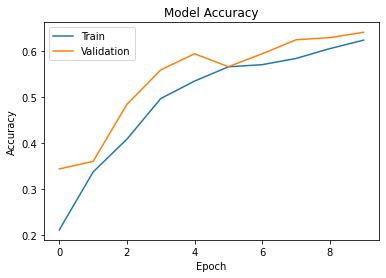

In [30]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* Pro: The valitation and training sets is within 1.5 of eachother so the the model is a performing well
* Con: The valitation accuracy is higher than the train accuracy so the model is underfit
* We will get rid of the dropout in the next model to fix this.
 

In [31]:
# Evaluating the model on test data
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.1652 - accuracy: 0.6063 - 949ms/epoch - 63ms/step


In [32]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

In [33]:
y_pred

array([[6.12179749e-04, 7.36689799e-07, 1.72751059e-03, ...,
        8.73843674e-04, 7.40746439e-01, 1.85643628e-01],
       [1.03548149e-10, 4.22000587e-02, 1.07163012e-01, ...,
        7.51153566e-04, 8.49538922e-01, 2.33902203e-04],
       [3.83903476e-04, 8.88153663e-05, 3.42097809e-03, ...,
        5.29067181e-02, 1.93165592e-03, 1.18106686e-01],
       ...,
       [1.18360622e-04, 3.88726890e-01, 3.67102057e-01, ...,
        8.91206414e-03, 1.46441087e-01, 2.68117767e-02],
       [4.06409377e-08, 3.08393511e-09, 7.00750036e-08, ...,
        5.99095374e-02, 3.07147205e-02, 1.88588782e-03],
       [4.54581380e-02, 1.19379151e-03, 8.57129917e-02, ...,
        1.24520026e-02, 1.41370529e-03, 8.98530632e-02]], dtype=float32)

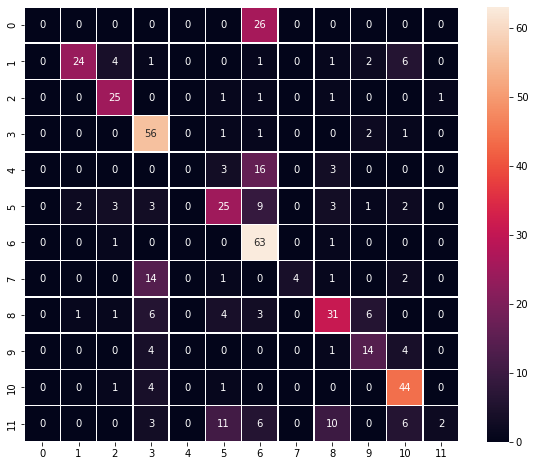

In [34]:
# Plotting the Confusion Matrix
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

* Classes (1,2,3,6,8, and 10) are performing the best.
* Classes (0,4,7,,9, and 11) show that the model needs to be improved apon.

### Model-2:  Model improvement

* Data Augmentation will be used
* Batch size will be increased to 64

#### Data Augmentation

In [49]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [50]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20, 
                              fill_mode='nearest'
                              )

In [51]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                        

In [52]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

In [54]:
# Epochs
epochs = 10
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(
      X_train_normalized,y_train_encoded,
      batch_size=batch_size, 
      seed=1,
      shuffle=False),
      epochs=epochs,
      steps_per_epoch=X_train_normalized.shape[0] // batch_size,
      validation_data=(X_val_normalized,y_val_encoded),
      class_weight=class_weights,
      verbose=1)

Epoch 1/10
60/60 [==============================] - 44s 725ms/step - loss: 2.1098 - accuracy: 0.3627 - val_loss: 2.2851 - val_accuracy: 0.2804
Epoch 2/10
60/60 [==============================] - 37s 612ms/step - loss: 1.4914 - accuracy: 0.5194 - val_loss: 2.1981 - val_accuracy: 0.2196
Epoch 3/10
60/60 [==============================] - 35s 584ms/step - loss: 1.1596 - accuracy: 0.6233 - val_loss: 2.0106 - val_accuracy: 0.2827
Epoch 4/10
60/60 [==============================] - 35s 583ms/step - loss: 1.0283 - accuracy: 0.6640 - val_loss: 1.7478 - val_accuracy: 0.3995
Epoch 5/10
60/60 [==============================] - 35s 585ms/step - loss: 0.9335 - accuracy: 0.7047 - val_loss: 1.5532 - val_accuracy: 0.5187
Epoch 6/10
60/60 [==============================] - 37s 613ms/step - loss: 0.7916 - accuracy: 0.7417 - val_loss: 1.4859 - val_accuracy: 0.5093
Epoch 7/10
60/60 [==============================] - 35s 579ms/step - loss: 0.7338 - accuracy: 0.7639 - val_loss: 1.4569 - val_accuracy: 0.4696

#### Model-2 Preformance Evaluation 

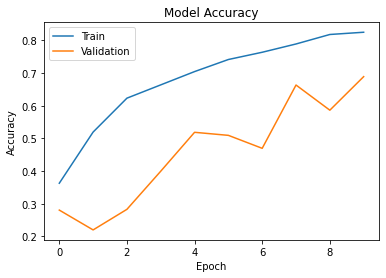

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* The accuracy for the validation and training set both increased. Now the training set is higher than the validation set. 
*Getting rid of droppout seemed to play a role in moving validation below the test set.
* Increasing the batch size to 64 lowered the validation set's accuracy at the 
beginning. Therefore, the batch size will be edited back to 32.
* The validation set's accuracy curve is unstable while the training set is nice and smooth.
* In next model lets re-introduce the dropout at 0.07

In [56]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 0.9022 - accuracy: 0.6737 - 919ms/epoch - 61ms/step


* Accuracy has improved a little.

In [57]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

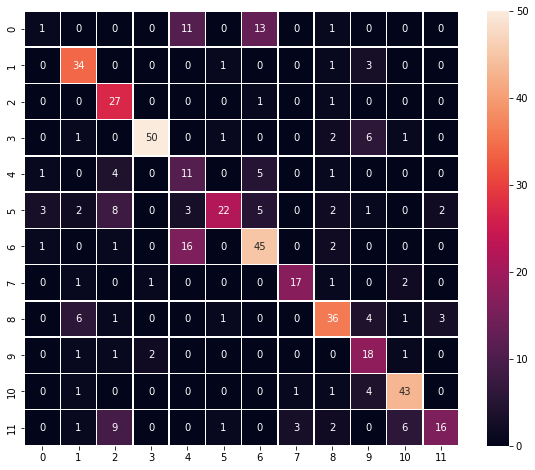

In [58]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

*Classes (1,2,3,5,6,8, and 10) are performing the best.
*Classes (0,4,7,,9, and 11) still need some improvement.
*Classes (4,7, and 11) have improved from last model.

#### Final Model

In [71]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

In [92]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.07))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model.add(Dense(12, activation='softmax'))

#Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)
# opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                      

In [93]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(1)
import random
random.seed(1)
tf.random.set_seed(1)

* This model contains data augmentation from model 2. 
* Epoch was planned to be increased to 15 but no benefit of increasing epoch was seen in the accuracy score. 
* From trial and error it was found that there was no benefit using more than 9 
epoch because the validation curve ends at 9 epoch 
* The plan was to have a dropout less than 0.1 at 0.7. No benifit of fixing the initial underfitting was seen so it is now commented out.
* Otpimizer was changed to SGD.

In [94]:
# Epochs
epochs = 9
# Batch size
batch_size = 32

history3 = model.fit(train_datagen.flow(
      X_train_normalized,y_train_encoded,
      batch_size=batch_size, 
      seed=1,
      shuffle=False),
      epochs=epochs,
      steps_per_epoch=X_train_normalized.shape[0] // batch_size,
      validation_data=(X_val_normalized,y_val_encoded),
      class_weight=class_weights,
      verbose=1)

Epoch 1/9
120/120 [==============================] - 41s 334ms/step - loss: 2.8503 - accuracy: 0.1269 - val_loss: 2.6689 - val_accuracy: 0.1285
Epoch 2/9
120/120 [==============================] - 37s 311ms/step - loss: 2.3481 - accuracy: 0.2988 - val_loss: 2.1001 - val_accuracy: 0.2547
Epoch 3/9
120/120 [==============================] - 38s 319ms/step - loss: 1.6029 - accuracy: 0.4878 - val_loss: 10.9531 - val_accuracy: 0.1285
Epoch 4/9
120/120 [==============================] - 38s 316ms/step - loss: 1.3662 - accuracy: 0.5633 - val_loss: 1.9308 - val_accuracy: 0.4159
Epoch 5/9
120/120 [==============================] - 38s 319ms/step - loss: 1.1848 - accuracy: 0.6050 - val_loss: 2.3913 - val_accuracy: 0.4136
Epoch 6/9
120/120 [==============================] - 37s 309ms/step - loss: 1.0953 - accuracy: 0.6482 - val_loss: 1.8996 - val_accuracy: 0.4977
Epoch 7/9
120/120 [==============================] - 37s 307ms/step - loss: 0.9872 - accuracy: 0.6799 - val_loss: 1.7143 - val_accuracy

#### Final Model Evaluation

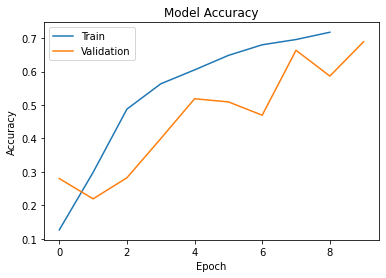

In [95]:
plt.plot(history3.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* The validation set is closer to the training set than model 2. 
* The training set is now above the validation set but still within 1.5 in some areas. 

In [96]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 1.5900 - accuracy: 0.5242 - 965ms/epoch - 64ms/step


In [97]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

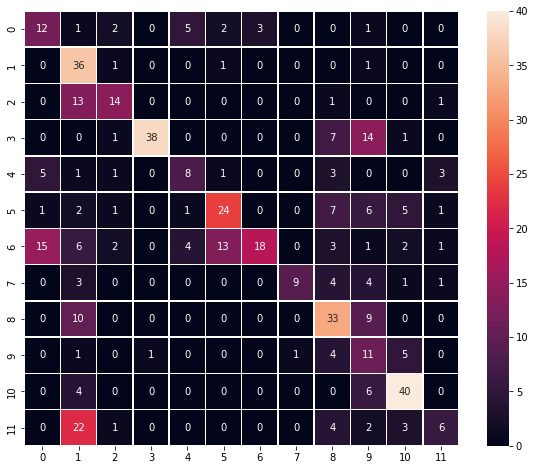

In [98]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

* The Final model has the best confusion matrix with all classes doing well. Some of the classes do not seem as high as when they where seen in model 2 and model 1. 

## **Visualizing the prediction:**

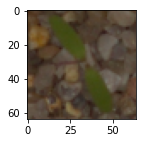

Predicted Label ['Fat Hen']
True Label Fat Hen


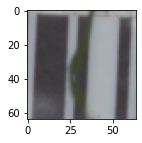

Predicted Label ['Black-grass']
True Label Black-grass


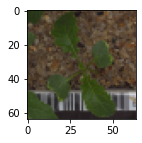

Predicted Label ['Charlock']
True Label Charlock


In [99]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

* These few images shown are correctly labeled. 

### Conclusion

The initial CNN model had the best fit with the validation and training sets. 
The 2nd model had the highest performance according to the confusion matrix and accuracy among all three sets. The final model had the lowest accuracy among the
validation and test sets. The final model is overfitted compared to the initial model. In the second and final model their was a struggle to smooth out the validation set and to bring it closer to the training set. 

The final model failed to improve apon the 2nd model. Increasing epoch above 10 was not effective. The final model used adam otimizer in a eailier trial and had better results, but still lower than model 2 performance. The highest test accuracy the final model ever recieved was 70%. Droppout being reduced or removed did not seem to play a rule in fitting the valitation set closer to the training set. Data augmentation on the final model did not significantly effect the accuracy score for any set. Decreasing batch size back to 32 did not smooth out the validation set. 


In [101]:
pd.DataFrame({'Models':['Initial CNN Model','CNN Model with Data Augmentation','Final:SGD Model with Data Augmentation'],'Train Accuracy':['62%','82%','71%'],'Validation Accuracy':['64%','68%','45%'],'Test Accuracy':['60%','67%','52%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Initial CNN Model,62%,64%,60%
1,CNN Model with Data Augmentation,82%,68%,67%
2,Final:SGD Model with Data Augmentation,71%,45%,52%


The 2nd model should be used for classifying the plant seedlings into their respective 12 categories. 

A future model should contain:
*Adam optimizer
*A droppout weight between 0.2 and 0.1 or try none at all
*Experimentaion with different activation functions
*data aumentation 
*balanace classes
*Experimentation with a larger image size and grey scale
